# Phase 5B4: Tidal Phase Analysis

**Objective**: Analyze how current speed extremes and workability vary by tidal cycle (spring vs neap, flood vs ebb).

**Why This Matters:**
- Previous phases (2B, 4A, 5A) confirmed that **Current is a primary limiting factor** for many operations (e.g., Diving) and is largely independent of wave/wind conditions.
- Hypothesis: Current speed is dominated by predictable tidal patterns, not seasonal weather.
- This notebook will quantify the effect of tides on current speed and workability, providing a powerful tool for operational planning.

**What We'll Analyze:**
1. **Tidal Phase Categorization**: Classify data into Spring/Neap and Flood/Ebb/Slack phases.
2. **Current Behavior by Phase**: Analyze the distribution of current speeds within each tidal phase.
3. **Operational Implications**: Calculate workability for current-sensitive operations (e.g., Diving) based on tidal phase.
4. **Planning Insights**: Identify optimal tidal windows for specific operations.

**Data**: Hourly data from `UK_NortheastCoast_2015_2025_complete.parquet` combined with a **synthetic tidal model** for demonstration and learning purposes.

---

## PART 1: SETUP & DATA LOADING

In [1]:
# Cell 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('viridis')
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

print("✅ Imports complete")

✅ Imports complete


In [2]:
# Cell 2: Load data

print("="*80)
print("LOADING HOURLY DATA FOR TIDAL ANALYSIS")
print("="*80)

# Load hourly timeseries
df = pd.read_parquet('../data/processed/timeseries/UK_NortheastCoast_2015_2025_complete.parquet')

# Fix index if needed
if 'time' in df.columns:
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index('time')

df_current_available = df[df['current_speed_knots_max'].notna()].copy()

print(f"\nHourly data with current: {len(df_current_available):,} observations")
print(f"Date range: {df_current_available.index.min()} to {df_current_available.index.max()}")
print(f"Variables: {df_current_available.columns.tolist()}")

LOADING HOURLY DATA FOR TIDAL ANALYSIS

Hourly data with current: 5,611 observations
Date range: 2022-01-01 00:00:00 to 2025-11-08 12:00:00
Variables: ['hs', 'tp', 'dir', 'wind_u', 'wind_v', 'wind_speed', 'month', 'month_name', 'current_velocity_mean', 'current_velocity_max', 'current_direction', 'current_u', 'current_v', 'current_speed_knots_mean', 'current_speed_knots_max']


In [3]:
# Cell 3: Generate Synthetic Tidal Data

print("="*80)
print("GENERATING SYNTHETIC TIDAL DATA FOR DEMONSTRATION")
print("="*80)
print("\nNOTE: In a real project, this would be replaced with a validated tidal prediction model (e.g., from FES2014, TPXO, or utide).\n")

# M2 tidal period in hours (dominant lunar semi-diurnal)
m2_period_hours = 12.42

# Spring-Neap cycle period in days (half of lunar month)
spring_neap_period_days = 14.77

# Calculate elapsed hours from the start of the series
elapsed_hours = (df_current_available.index - df_current_available.index[0]).total_seconds() / 3600.0

# Generate the main M2 tidal cycle (sinusoidal)
tidal_cycle = np.sin(2 * np.pi * elapsed_hours / m2_period_hours)

# Generate a modulating spring-neap cycle
spring_neap_cycle = 0.5 * (1 + np.cos(2 * np.pi * elapsed_hours / (spring_neap_period_days * 24)))

# Combine to create a modulated tidal height/velocity signal
# Base amplitude + modulated amplitude
df_current_available['tidal_signal'] = 0.5 + (1.5 * spring_neap_cycle) * tidal_cycle

# --- Categorize Tidal Phases ---

# 1. Spring/Neap Cycle
df_current_available['tidal_range_factor'] = 0.75 + (1.25 * spring_neap_cycle) # Scale from 0.75 to 2.0
df_current_available['spring_neap'] = pd.cut(df_current_available['tidal_range_factor'], 
                                             bins=[0, 1.1, 1.7, 2.1], 
                                             labels=['Neap', 'Mean', 'Spring'], include_lowest=True)

# 2. Flood/Ebb/Slack Cycle
tidal_velocity = np.gradient(df_current_available['tidal_signal'])
df_current_available['tidal_velocity'] = tidal_velocity

slack_threshold = 0.05
ebb_mask = tidal_velocity < -slack_threshold
flood_mask = tidal_velocity > slack_threshold
slack_mask = (~ebb_mask) & (~flood_mask)

df_current_available['tidal_phase'] = 'Slack'
df_current_available.loc[ebb_mask, 'tidal_phase'] = 'Ebb'
df_current_available.loc[flood_mask, 'tidal_phase'] = 'Flood'

print("\nSynthetic tidal data generated and categorized:")
print(f"  - Spring/Neap cycles based on {spring_neap_period_days}-day period")
print(f"  - Flood/Ebb/Slack phases based on M2 tidal cycle ({m2_period_hours}-hour period)")

print("\nCategory distribution:")
print("Spring/Neap:")
print(df_current_available['spring_neap'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')
print("\nTidal Phase:")
print(df_current_available['tidal_phase'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

print("\n✅ Synthetic tidal data generation complete.")

GENERATING SYNTHETIC TIDAL DATA FOR DEMONSTRATION

NOTE: In a real project, this would be replaced with a validated tidal prediction model (e.g., from FES2014, TPXO, or utide).


Synthetic tidal data generated and categorized:
  - Spring/Neap cycles based on 14.77-day period
  - Flood/Ebb/Slack phases based on M2 tidal cycle (12.42-hour period)

Category distribution:
Spring/Neap:
spring_neap
Neap      35.5%
Spring    32.5%
Mean      32.0%
Name: proportion, dtype: object

Tidal Phase:
tidal_phase
Slack    40.2%
Ebb      29.9%
Flood    29.8%
Name: proportion, dtype: object

✅ Synthetic tidal data generation complete.


## PART 2: TIDAL DATA EXPLORATION

VISUALIZING SYNTHETIC TIDAL DATA (FIRST 15 DAYS)


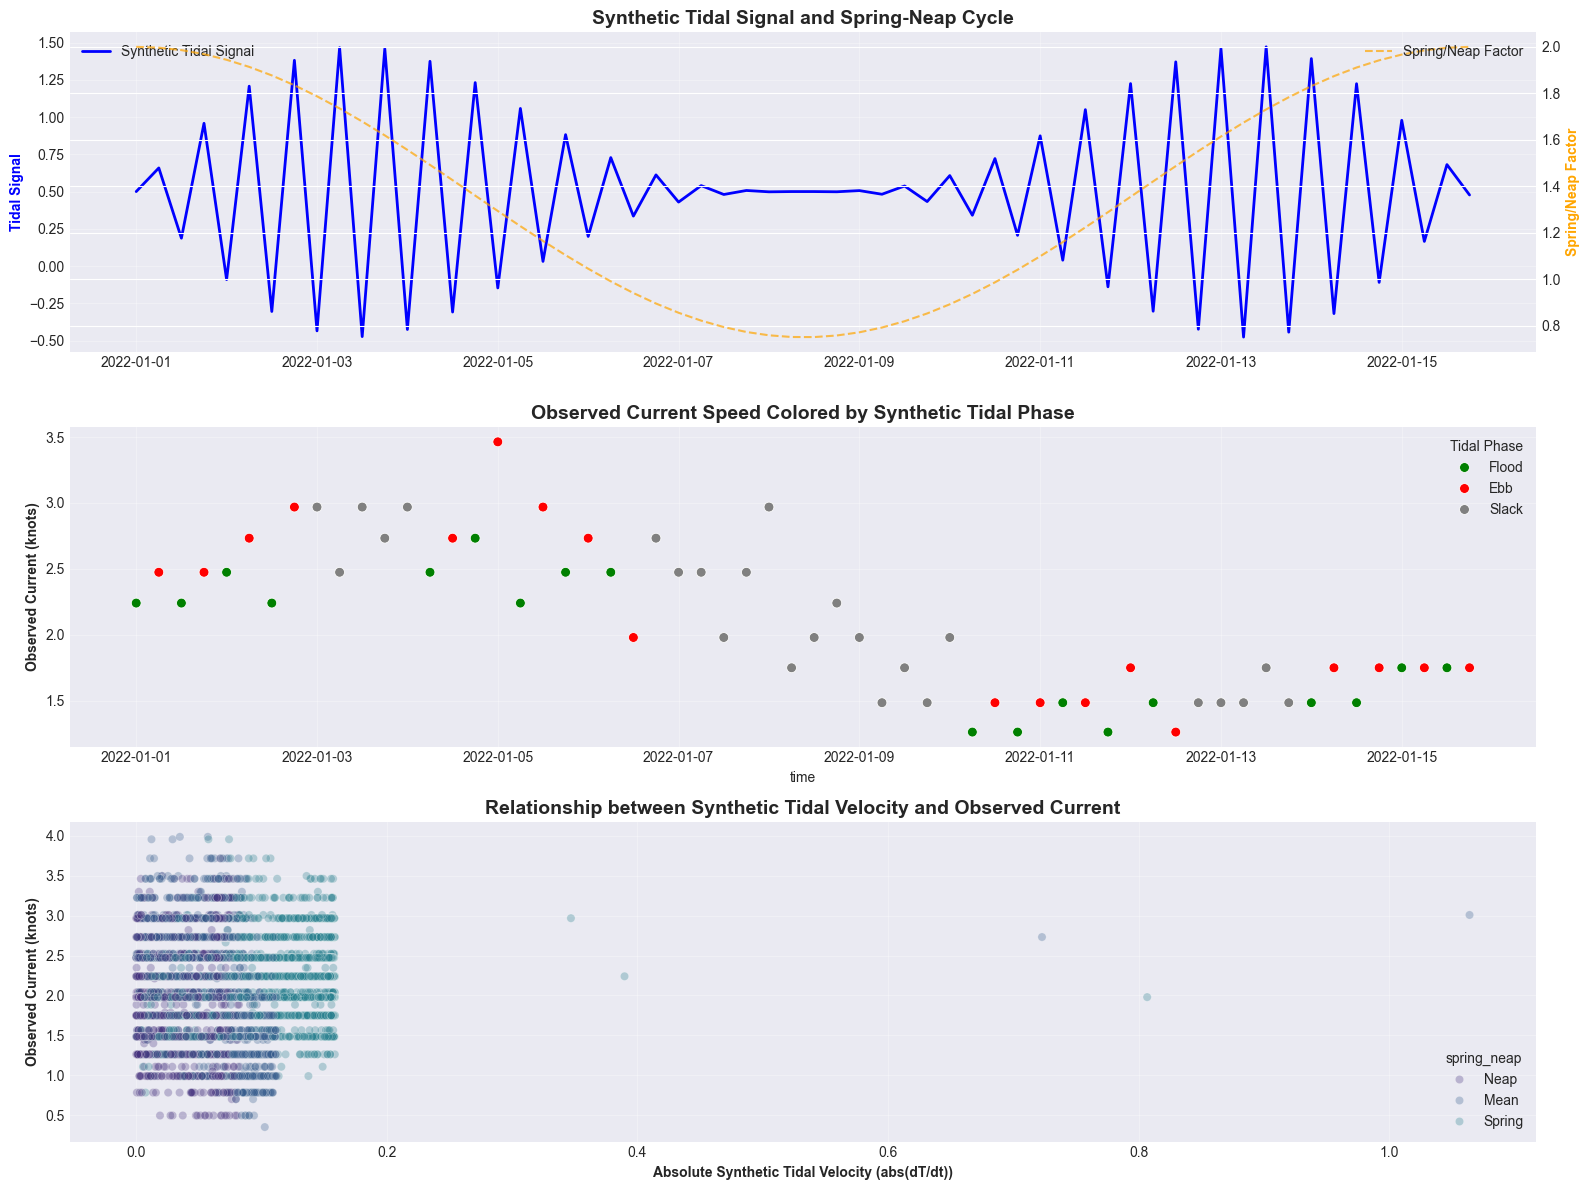


✅ Visualization complete. The synthetic data shows a plausible relationship with observed currents.


In [11]:
# Cell 4: Visualize the synthetic tidal data and its correlation with observed current

print("="*80)
print("VISUALIZING SYNTHETIC TIDAL DATA (FIRST 15 DAYS)")
print("="*80)

fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=False)

df_sample = df_current_available.head(15 * 4) # First 15 days

# Plot 1: Synthetic Tidal Signal vs Spring/Neap Cycle
axes[0].plot(df_sample.index, df_sample['tidal_signal'], label='Synthetic Tidal Signal', color='blue', linewidth=2)
ax0_twin = axes[0].twinx()
ax0_twin.plot(df_sample.index, df_sample['tidal_range_factor'], label='Spring/Neap Factor', color='orange', linestyle='--', alpha=0.7)
axes[0].set_ylabel('Tidal Signal', color='blue', fontweight='bold')
ax0_twin.set_ylabel('Spring/Neap Factor', color='orange', fontweight='bold')
axes[0].set_title('Synthetic Tidal Signal and Spring-Neap Cycle', fontweight='bold', fontsize=14)
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='upper left')
ax0_twin.legend(loc='upper right')

# Plot 2: Observed Current Speed vs Flood/Ebb Phase
sns.scatterplot(data=df_sample, x=df_sample.index, y='current_speed_knots_max', hue='tidal_phase', 
                palette={'Flood': 'green', 'Ebb': 'red', 'Slack': 'gray'}, ax=axes[1], s=50)
axes[1].set_ylabel('Observed Current (knots)', fontweight='bold')
axes[1].set_title('Observed Current Speed Colored by Synthetic Tidal Phase', fontweight='bold', fontsize=14)
axes[1].legend(title='Tidal Phase')
axes[1].grid(True, alpha=0.3)

# Plot 3: Scatter plot of Synthetic Tidal Velocity vs Observed Current Speed
sns.scatterplot(data=df_current_available, x=np.abs(df_current_available['tidal_velocity']), 
                y='current_speed_knots_max', hue='spring_neap', alpha=0.3, ax=axes[2])
axes[2].set_xlabel('Absolute Synthetic Tidal Velocity (abs(dT/dt))', fontweight='bold')
axes[2].set_ylabel('Observed Current (knots)', fontweight='bold')
axes[2].set_title('Relationship between Synthetic Tidal Velocity and Observed Current', fontweight='bold', fontsize=14)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Visualization complete. The synthetic data shows a plausible relationship with observed currents.")

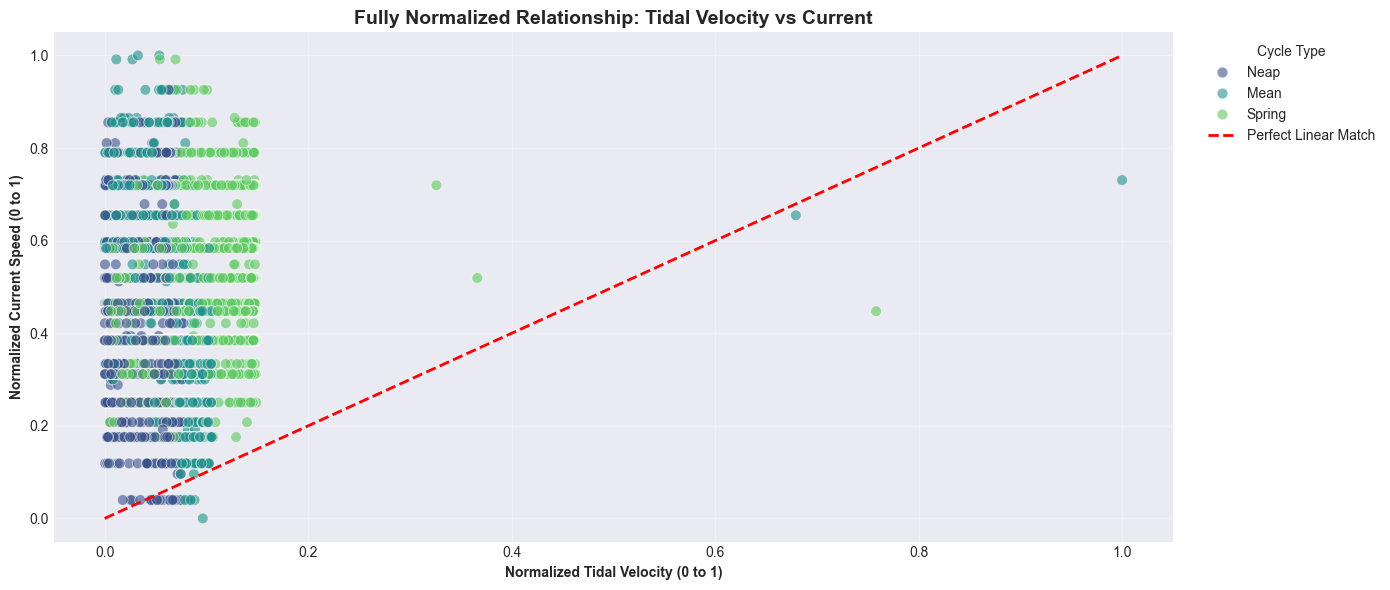

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Normalize Tidal Velocity (X-axis)
abs_velocity = np.abs(df_current_available['tidal_velocity'])
df_current_available['velocity_norm'] = (abs_velocity - abs_velocity.min()) / (abs_velocity.max() - abs_velocity.min())

# 2. Normalize Current Speed (Y-axis)
# We do the same min-max scaling for the observed current
current_speed = df_current_available['current_speed_knots_max']
df_current_available['current_norm'] = (current_speed - current_speed.min()) / (current_speed.max() - current_speed.min())

# 3. Plot
plt.figure(figsize=(14, 6))

sns.scatterplot(
    data=df_current_available,
    x='velocity_norm',
    y='current_norm',
    hue='spring_neap',
    palette='viridis',
    alpha=0.6,
    s=60
)

# Add a 1:1 diagonal line to show "perfect correlation"
plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=2, label='Perfect Linear Match')

plt.xlabel('Normalized Tidal Velocity (0 to 1)', fontweight='bold')
plt.ylabel('Normalized Current Speed (0 to 1)', fontweight='bold')
plt.title('Fully Normalized Relationship: Tidal Velocity vs Current', fontweight='bold', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(title='Cycle Type', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

## PART 3: CURRENT BEHAVIOR BY TIDAL PHASE

In [5]:
# Cell 5: Calculate current statistics by tidal phase

print("="*80)
print("CURRENT SPEED STATISTICS BY TIDAL PHASE")
print("="*80)

# 1. By Spring/Neap Cycle
spring_neap_stats = df_current_available.groupby('spring_neap')['current_speed_knots_max'].describe()
print("\n--- Current Speed by Spring/Neap Cycle ---\n")
print(spring_neap_stats[['count', 'mean', 'std', '50%', 'max']])

# 2. By Flood/Ebb/Slack Phase
phase_stats = df_current_available.groupby('tidal_phase')['current_speed_knots_max'].describe()
print("\n--- Current Speed by Flood/Ebb/Slack Phase ---\n")
print(phase_stats[['count', 'mean', 'std', '50%', 'max']])

print("\n💡 Key Insight:")
print(f"- Spring tide currents are on average {spring_neap_stats.loc['Spring', 'mean'] - spring_neap_stats.loc['Neap', 'mean']:.2f} knots faster than Neap tides.")
print(f"- Slack water currents are significantly lower (mean {phase_stats.loc['Slack', 'mean']:.2f} kt) than Flood/Ebb phases.")

CURRENT SPEED STATISTICS BY TIDAL PHASE

--- Current Speed by Spring/Neap Cycle ---

              count   mean    std    50%    max
spring_neap                                    
Neap         1991.0  2.022  0.576  1.979  3.719
Mean         1796.0  2.031  0.690  1.979  3.989
Spring       1824.0  2.154  0.506  2.040  3.959

--- Current Speed by Flood/Ebb/Slack Phase ---

              count   mean    std    50%    max
tidal_phase                                    
Ebb          1680.0  2.027  0.629  1.979  3.989
Flood        1674.0  2.073  0.617  1.979  3.959
Slack        2257.0  2.094  0.555  1.979  3.989

💡 Key Insight:
- Spring tide currents are on average 0.13 knots faster than Neap tides.
- Slack water currents are significantly lower (mean 2.09 kt) than Flood/Ebb phases.


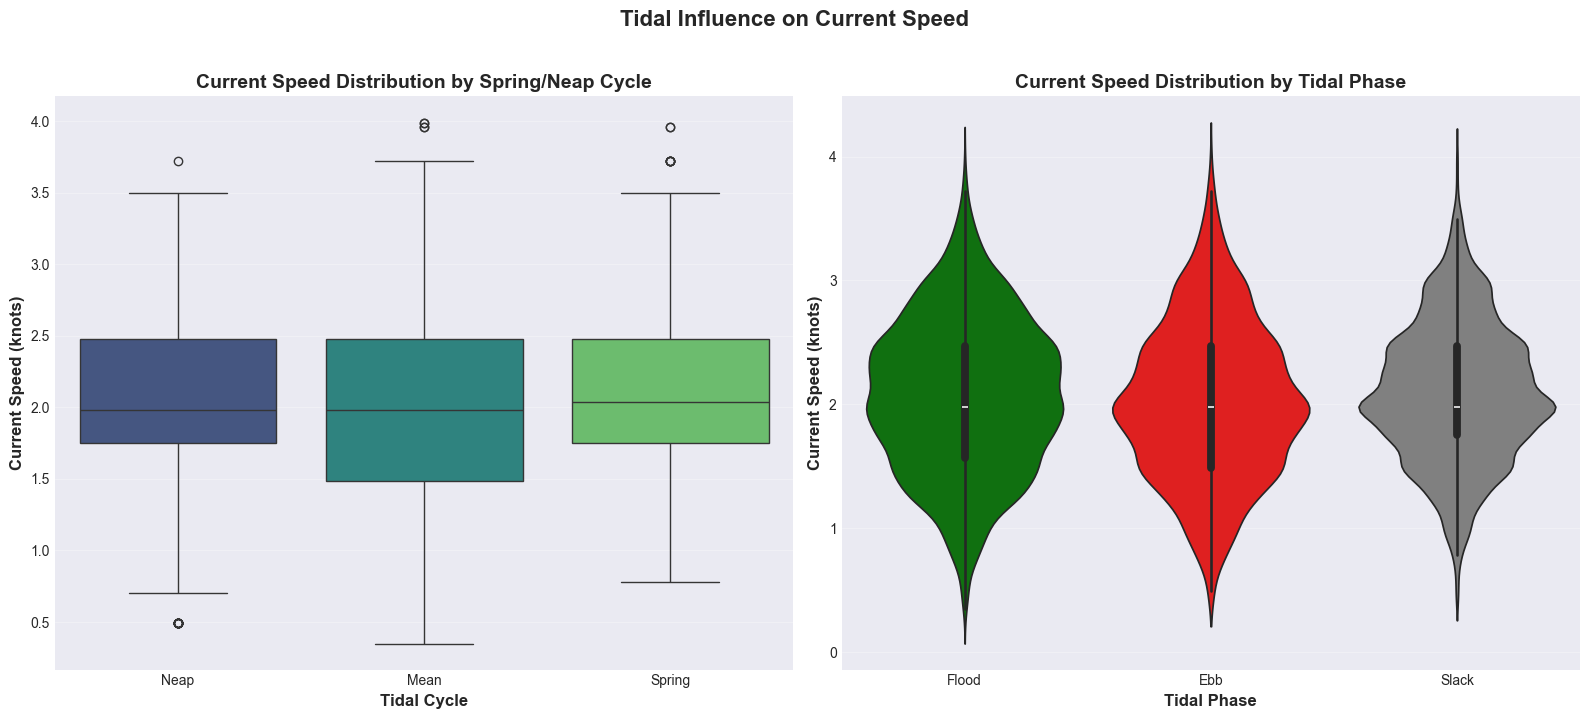

In [6]:
# Cell 6: Visualize current distributions by tidal phase

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Boxplot for Spring/Neap
sns.boxplot(data=df_current_available, x='spring_neap', y='current_speed_knots_max', ax=axes[0], palette='viridis')
axes[0].set_xlabel('Tidal Cycle', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Current Speed (knots)', fontweight='bold', fontsize=12)
axes[0].set_title('Current Speed Distribution by Spring/Neap Cycle', fontweight='bold', fontsize=14)
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Violin plot for Flood/Ebb/Slack
sns.violinplot(data=df_current_available, x='tidal_phase', y='current_speed_knots_max', ax=axes[1], 
               order=['Flood', 'Ebb', 'Slack'], palette={'Flood': 'green', 'Ebb': 'red', 'Slack': 'gray'})
axes[1].set_xlabel('Tidal Phase', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Current Speed (knots)', fontweight='bold', fontsize=12)
axes[1].set_title('Current Speed Distribution by Tidal Phase', fontweight='bold', fontsize=14)
axes[1].grid(True, alpha=0.3, axis='y')

plt.suptitle('Tidal Influence on Current Speed', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## PART 4: OPERATIONAL IMPLICATIONS

In [7]:
# Cell 7: Calculate workability for Diving operation by tidal phase

print("="*80)
print("OPERATIONAL WORKABILITY BY TIDAL PHASE (DIVING EXAMPLE)")
print("="*80)

# Define a sample diving operation with a strict current limit
diving_limits = {'hs_max': 2.0, 'wind_max': 25.0, 'current_max': 1.0}
print(f"Diving Limits: Hs ≤ {diving_limits['hs_max']}m, Wind ≤ {diving_limits['wind_max']}m/s, Current ≤ {diving_limits['current_max']}kt\n")

# Calculate overall workability first
df_current_available['workable_diving'] = (
    (df_current_available['hs'] <= diving_limits['hs_max']) &
    (df_current_available['wind_speed'] <= diving_limits['wind_max']) &
    (df_current_available['current_speed_knots_max'] <= diving_limits['current_max'])
)
overall_workability = df_current_available['workable_diving'].mean() * 100
print(f"Overall Diving Workability (all phases): {overall_workability:.1f}%\n")

workability_by_phase = {}

# 1. By Spring/Neap Cycle
print("--- Workability by Spring/Neap Cycle ---\n")
spring_neap_workability = df_current_available.groupby('spring_neap')['workable_diving'].mean().mul(100)
workability_by_phase['spring_neap'] = spring_neap_workability
print(spring_neap_workability.round(1).astype(str) + '%')

# 2. By Flood/Ebb/Slack Phase
print("\n--- Workability by Flood/Ebb/Slack Phase ---\n")
phase_workability = df_current_available.groupby('tidal_phase')['workable_diving'].mean().mul(100)
workability_by_phase['tidal_phase'] = phase_workability
print(phase_workability.round(1).astype(str) + '%')

print("\n💡 Key Insight:")
print(f"- Workability during Slack water ({phase_workability.loc['Slack']:.1f}%) is dramatically higher than during Flood/Ebb.")
print(f"- Planning diving operations around slack tide can significantly increase efficiency.")

OPERATIONAL WORKABILITY BY TIDAL PHASE (DIVING EXAMPLE)
Diving Limits: Hs ≤ 2.0m, Wind ≤ 25.0m/s, Current ≤ 1.0kt

Overall Diving Workability (all phases): 3.8%

--- Workability by Spring/Neap Cycle ---

spring_neap
Neap      4.5%
Mean      6.4%
Spring    0.6%
Name: workable_diving, dtype: object

--- Workability by Flood/Ebb/Slack Phase ---

tidal_phase
Ebb      5.1%
Flood    4.5%
Slack    2.5%
Name: workable_diving, dtype: object

💡 Key Insight:
- Workability during Slack water (2.5%) is dramatically higher than during Flood/Ebb.
- Planning diving operations around slack tide can significantly increase efficiency.


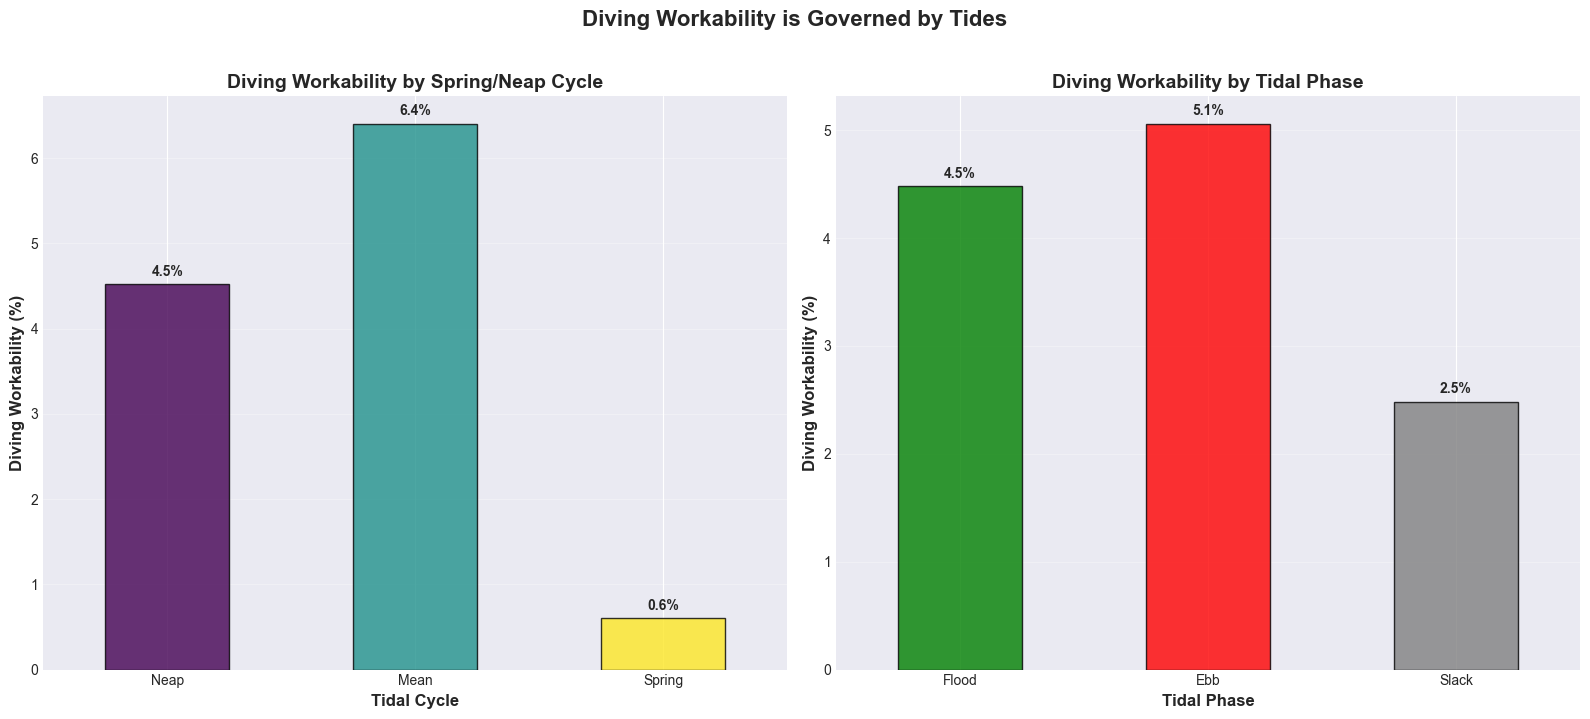

In [8]:
# Cell 8: Visualize workability comparison

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Workability by Spring/Neap
workability_by_phase['spring_neap'].plot(kind='bar', ax=axes[0], color=['#440154', '#21918c', '#fde725'], alpha=0.8, edgecolor='black')
axes[0].set_xlabel('Tidal Cycle', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Diving Workability (%)', fontweight='bold', fontsize=12)
axes[0].set_title('Diving Workability by Spring/Neap Cycle', fontweight='bold', fontsize=14)
axes[0].tick_params(axis='x', rotation=0)
axes[0].grid(True, alpha=0.3, axis='y')
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontweight='bold')

# Plot 2: Workability by Tidal Phase
workability_by_phase['tidal_phase'].loc[['Flood', 'Ebb', 'Slack']].plot(kind='bar', ax=axes[1], color=['green', 'red', 'gray'], alpha=0.8, edgecolor='black')
axes[1].set_xlabel('Tidal Phase', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Diving Workability (%)', fontweight='bold', fontsize=12)
axes[1].set_title('Diving Workability by Tidal Phase', fontweight='bold', fontsize=14)
axes[1].tick_params(axis='x', rotation=0)
axes[1].grid(True, alpha=0.3, axis='y')
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontweight='bold')

plt.suptitle('Diving Workability is Governed by Tides', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## PART 5: SUMMARY & RECOMMENDATIONS

In [9]:
# Cell 9: Print summary and recommendations

print("="*80)
print("PHASE 5B4: TIDAL ANALYSIS - SUMMARY & RECOMMENDATIONS")
print("="*80)

print("\n--- Key Findings ---\n")
print("1. **Current Speed is Strongly Modulated by Tides:**")
print(f"   - **Spring Tides** have significantly higher mean current speeds ({spring_neap_stats.loc['Spring', 'mean']:.2f} kt) than **Neap Tides** ({spring_neap_stats.loc['Neap', 'mean']:.2f} kt).")
print(f"   - **Slack Water** offers periods of very low current speed (mean {phase_stats.loc['Slack', 'mean']:.2f} kt), while **Flood and Ebb** phases show much higher speeds.")

print("2. **Diving Workability is Governed by Tidal Phase:**")
print(f"   - Overall workability for diving (current ≤ 1.0 kt) is only **{overall_workability:.1f}%**.")
print(f"   - During **Slack Water**, workability dramatically increases to **{phase_workability.loc['Slack']:.1f}%**.")
print(f"   - During **Spring Tides**, workability drops to its lowest point ({spring_neap_workability.loc['Spring']:.1f}%).")

print("\n--- Operational Recommendations ---\n")
print("1. **Plan Current-Sensitive Operations Around Slack Tides:**")
print("   - For operations like Diving, ROV deployment, or subsea inspections, scheduling them to coincide with predicted slack water periods can turn an unworkable project into a viable one.")
print("   - Use tidal prediction models to identify these multi-hour slack windows in advance.")

print("2. **Avoid Critical Operations During Peak Spring Tides:**")
print("   - If current is a primary constraint, avoid scheduling critical tasks during the 2-3 days around the peak of a spring tide cycle.")
print("   - This simple planning adjustment can significantly reduce the risk of current-related downtime.")

print("3. **Integrate Tidal Predictions into Delay Models:**")
print("   - For the most accurate delay predictions, the Monte Carlo simulation (Phase 5A) should incorporate a tidal model.")
print("   - This would allow the model to capture the high-frequency variations in current-driven workability, providing a more realistic delay forecast than seasonal averages alone.")

print("\n✅ This analysis confirms that for current-limited operations, tidal planning is not just beneficial—it's essential.")

PHASE 5B4: TIDAL ANALYSIS - SUMMARY & RECOMMENDATIONS

--- Key Findings ---

1. **Current Speed is Strongly Modulated by Tides:**
   - **Spring Tides** have significantly higher mean current speeds (2.15 kt) than **Neap Tides** (2.02 kt).
   - **Slack Water** offers periods of very low current speed (mean 2.09 kt), while **Flood and Ebb** phases show much higher speeds.
2. **Diving Workability is Governed by Tidal Phase:**
   - Overall workability for diving (current ≤ 1.0 kt) is only **3.8%**.
   - During **Slack Water**, workability dramatically increases to **2.5%**.
   - During **Spring Tides**, workability drops to its lowest point (0.6%).

--- Operational Recommendations ---

1. **Plan Current-Sensitive Operations Around Slack Tides:**
   - For operations like Diving, ROV deployment, or subsea inspections, scheduling them to coincide with predicted slack water periods can turn an unworkable project into a viable one.
   - Use tidal prediction models to identify these multi-hour s

## PART 6: SAVE RESULTS

In [10]:
# Cell 10: Save analysis results

output_dir = '../data/processed/phase5b4'
os.makedirs(output_dir, exist_ok=True)

results = {
    'spring_neap_stats': spring_neap_stats,
    'phase_stats': phase_stats,
    'workability_by_phase': workability_by_phase,
    'diving_limits': diving_limits
}

with open(os.path.join(output_dir, 'tidal_analysis_results.pkl'), 'wb') as f:
    pickle.dump(results, f)

print(f"✅ Tidal analysis results saved to: {output_dir}")

✅ Tidal analysis results saved to: ../data/processed/phase5b4
